### INTRODUZIONE 
L’analisi implementata si concentra sulla costruzione e lo studio di un grafo orientato per modellare la **propagazione** dell’influenza nelle reti sociali digitali, come Instagram o Threads. Questi grafi rappresentano le relazioni tra **utenti** e il flusso di contenuti, offrendo una base strutturata per comprendere le dinamiche di influenza, i meccanismi di diffusione virale e i fattori che le influenzano.
Nel modello presentato, la rete sociale è rappresentata utilizzando un oggetto nx.DiGraph della libreria NetworkX. In questa rappresentazione, i nodi corrispondono agli utenti, mentre gli archi orientati descrivono le relazioni **"follower-seguito"**. Un arco 𝐴→𝐵 indica che l’utente 𝐴 segue 𝐵, suggerendo una potenziale influenza di 𝐵 su 𝐴. 
La costruzione del grafo avviene iterando su un dataset che associa ciascun utente ai suoi follower, aggiungendo nodi per gli utenti e creando archi per rappresentare queste relazioni direzionali. Dal punto di vista teorico, i grafi orientati sono strumenti potenti per lo studio della propagazione dell’informazione e dell’influenza. In una rete sociale come Threads, ad esempio, post, risposte e like si propagano lungo gli archi direzionali, spinti da dinamiche di visibilità e interesse. Questa struttura consente di analizzare pattern di interazione, individuare **nodi strategici** e identificare sottogruppi di utenti (community), elementi fondamentali per comprendere il comportamento collettivo.

In [1]:
%pip install pandas numpy networkx matplotlib scikit-learn --quiet

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
import random
import json

# Preprocessing dei dati

In [3]:
df_posts = pd.read_csv("../../../data/post_data.csv")
df_replies = pd.read_csv("../../../data/replies_data.csv")
follower = "../../../data/output.json"
with open(follower, "r", encoding="utf-8") as file:
    dati = json.load(file)

In [4]:
missing_columns_in_posts = [col for col in df_replies.columns if col not in df_posts.columns]

for col in missing_columns_in_posts:
    df_posts[col] = np.nan

df_combined = pd.concat([df_posts, df_replies], ignore_index=True)
df_combined.columns = [col.lower().replace(" ", "_") for col in df_combined.columns]
df_combined.drop(columns=["parent_post_id","direct_reply_count"	,"repost_count","following","followed_by","can_reply","reply_control","reshare_count","is_verified"],axis=1,inplace=True)
df_combined.head()

,post_id,user_id,thread_type,username,profile_picture_url,text_post,like_count,quote_count,caption_text
0,3481594135434044840,62926993725,thread,simolude_ai,https://scontent-fco2-1.cdninstagram.com/v/t51...,Aston Martin for you.\r\n\r\nFor more pics ple...,7,0.0,Aston Martin for you.\r\n\r\nFor more pics ple...
1,3482097309088055950,38077850387,thread,vita.consacrata,https://scontent-fco2-1.cdninstagram.com/v/t51...,#genere #intelligenzaartificiale,0,0.0,#genere #intelligenzaartificiale
2,3481793127636829981,1501070805,thread,robymagno65,https://scontent-fco2-1.cdninstagram.com/v/t51...,#intelligenzaartificiale #foto #ottobre #fotog...,2,0.0,#intelligenzaartificiale #foto #ottobre #fotog...
3,3438852681247108598,65532133383,thread,news.scienze,https://scontent-fco2-1.cdninstagram.com/v/t51...,La conoscenza della macchina intesa come Intel...,3,0.0,La conoscenza della macchina intesa come Intel...
4,3446085903746401933,24736383042,thread,rakesh_yadav_200k,https://scontent-fco2-1.cdninstagram.com/v/t51...,#IntelligenzaArtificiale,21,0.0,#IntelligenzaArtificiale


In [5]:
df_combined.shape

(23052, 9)

In [7]:
df = df_combined.drop_duplicates()
# 2. Riempimento dei NaN nelle colonne di conteggio con 0 (queste colonne sono quantitative)
df['like_count'] = df['like_count'].fillna(0)
df['quote_count'] = df['quote_count'].fillna(0)

# 3. Conversione dei tipi di dati
# Assicuriamoci che i conteggi siano di tipo intero
count_columns = ['like_count', 'quote_count']

for col in count_columns:
    df[col] = df[col].astype(int)

# Identificazione degli utenti influenti

In [8]:
G = nx.DiGraph()
for user_id, user_data in dati.items():
    user_info = df.loc[df['user_id'] == int(user_id)].to_dict(orient='records')
    
    
    if not G.has_node(int(user_id)):
        G.add_node(int(user_id), info=user_info)

    followers = user_data.get("followers", [])
    for follower in followers:
        follower_username = int(follower["user_id"])

        follower_info = df.loc[df['user_id'] == follower_username].to_dict(orient='records')

        if not G.has_node(follower_username):
            G.add_node(follower_username, info=follower_info)

        G.add_edge(follower_username, int(user_id))





G_info = {
    'numero_nodi': G.number_of_nodes(),
    'numero_archi': G.number_of_edges(),
    'esempio_nodi': list(G.nodes(data=True))[:5],  # Prime 5 nodi con attributi
    'esempio_archi': list(G.edges(data=True))[:5]  # Prime 5 archi con attributi
}

G_info


{'numero_nodi': 43312,
 'numero_archi': 44104,
 'esempio_nodi': [(62926993725,
   {'info': [{'post_id': 3481594135434044840,
      'user_id': 62926993725,
      'thread_type': 'thread',
      'username': 'simolude_ai',
      'profile_picture_url': 'https://scontent-fco2-1.cdninstagram.com/v/t51.2885-19/459032079_1450255862352365_3270406893771965895_n.jpg?stp=dst-jpg_s150x150&_nc_ht=scontent-fco2-1.cdninstagram.com&_nc_cat=105&_nc_ohc=s-ew1TENjzQQ7kNvgHPIBiH&_nc_gid=57f2378e344348039cdf965dba35abb5&edm=APs17CUBAAAA&ccb=7-5&oh=00_AYCmx6E8PHp6Ba2EOJ6_JnrThgiQqYLmzAFD_zz0pisOzA&oe=67194644&_nc_sid=10d13b',
      'text_post': 'Aston Martin for you.\r\n\r\nFor more pics please follow ',
      'like_count': 7,
      'quote_count': 0,
      'caption_text': 'Aston Martin for you.\r\n\r\nFor more pics please follow @simolude_ai\r\n#render #design #intelligenzaartificiale #aiart  #aiphotography  #aicar  #aiartwork  #aiartcommunity  #ai  #aicars  #aiartist  #aicommunity #carspotted\r\n#automotive 

In [12]:

centralities = {
    #'Degree Centrality': nx.degree_centrality(G),
    #'Closeness Centrality': nx.closeness_centrality(G),
    #'Betweenness Centrality': nx.betweenness_centrality(G, normalized=True, weight='weight'),
    'PageRank': nx.pagerank(G, alpha=0.85),
    #'Katz Centrality': nx.katz_centrality(G, alpha=0.1, beta=1.0, max_iter=1000, tol=1e-06),
    #'Eigenvector Centrality': nx.eigenvector_centrality(G, max_iter=1000),
    #'HITS Hub Scores': nx.hits(G, max_iter=1000, tol=1e-08)[0],
    #'HITS Authority Scores': nx.hits(G, max_iter=1000, tol=1e-08)[1]
}

def print_top_centralities(top_n=10):
    for name, values in centralities.items():
        print(f"\nTop {top_n} utenti per {name}:")
        top_nodes = sorted(values.items(), key=lambda x: x[1], reverse=True)[:top_n]
        for i, (node, score) in enumerate(top_nodes, start=1):
            print(f"{i}. Nodo {node}: {score:.4f}")

print_top_centralities()


Top 10 utenti per PageRank:
1. Nodo 56678084668: 0.0024
2. Nodo 60220452727: 0.0024
3. Nodo 2487286295: 0.0019
4. Nodo 62773533876: 0.0018
5. Nodo 1474648683: 0.0017
6. Nodo 12167060274: 0.0017
7. Nodo 983607: 0.0013
8. Nodo 251479926: 0.0013
9. Nodo 1824051562: 0.0011
10. Nodo 59967642519: 0.0011


Nella teoria delle reti sociali, l'analisi delle centralità fornisce una visione profonda dell'influenza e della posizione relativa di ogni nodo (utente) all'interno della rete. Le metriche di centralità sono strumenti matematici che misurano l'importanza di un nodo rispetto agli altri in una rete, e sono fondamentali per comprendere la diffusione dell'informazione, dell'influenza o della risorsa in una rete sociale.

### Degree Centrality
La degree centrality è una delle metriche più semplici e si basa sul numero di connessioni dirette che un nodo ha. In una rete sociale, un nodo con un alto valore di degree centrality è ben connesso e può essere visto come un utente con un alto potenziale di influenza immediata. Più un nodo è connesso ad altri utenti, maggiore è la sua visibilità e la sua capacità di diffondere contenuti. Nel nostro caso, i primi dieci utenti per degree centrality sono tutti caratterizzati da un valore identico di 0.0012, il che suggerisce una distribuzione relativamente uniforme delle connessioni dirette tra questi utenti. Nonostante ciò, il valore di degree centrality di per sé non fornisce indicazioni su come le connessioni siano distribuite o sull'importanza dei vicini con cui un nodo interagisce, ma solo sulla quantità di legami diretti.

### Closeness Centrality
La closeness centrality misura quanto un nodo è vicino agli altri nodi della rete in termini di distanza. Un nodo con alta closeness centrality ha una posizione centrale nella rete e può diffondere informazioni più velocemente rispetto agli altri nodi. Questo è dovuto alla sua capacità di raggiungere rapidamente altri nodi attraverso i percorsi più brevi. Nel caso della closeness, i nodi con valori più alti (come il nodo 45123667565 con un valore di 0.0017) sono più efficienti nella diffusione dell'informazione. I top utenti per questa centralità hanno valori abbastanza vicini, il che indica che non ci sono grandi differenze tra gli utenti più centrali in termini di efficienza di diffusione.

### Betweenness Centrality
La betweenness centrality misura quanto un nodo agisca come intermediario tra altri nodi, ossia quanto un nodo "controlli" il flusso di informazioni che passa attraverso la rete. Un alto valore di betweenness centrality indica che il nodo funge da ponte tra diverse parti della rete e quindi ha un'influenza potenziale nell'interscambio di informazioni. In questo caso, i primi dieci nodi hanno tutti un valore di betweenness centrality pari a 0, il che suggerisce che nella rete analizzata non vi siano nodi che svolgano un ruolo centrale nel controllo dei flussi informativi, almeno secondo questa misura.

### PageRank
Il PageRank è una metrica che prende in considerazione sia il numero di connessioni di un nodo sia l'importanza dei nodi che lo collegano. Originariamente sviluppato per classificare le pagine web, in una rete sociale un alto PageRank indica che un nodo è seguito da altri nodi importanti. Gli utenti con alti valori di PageRank (ad esempio, il nodo 56678084668 con un valore di 0.0024) sono tipicamente nodi che, pur non essendo necessariamente molto connessi, sono influenti perché sono legati ad altri nodi influenti. Questo valore può essere utilizzato per identificare i nodi che, pur non avendo un alto numero di follower, sono al centro di un "flusso" informativo più ricco e influente.

### Katz Centrality
La Katz centrality è simile alla PageRank, ma introduce una penalizzazione per i nodi più lontani, pesando più fortemente le connessioni vicine. Una Katz centrality alta suggerisce che un nodo ha molti vicini influenti e può diffondere contenuti con maggiore efficacia. I nodi nella top 10 per Katz Centrality (ad esempio, il nodo 24736383042 con un valore di 0.0241) sono caratterizzati da un valore elevato, suggerendo una grande influenza attraverso il grafo, con connessioni che riflettono sia la quantità che la qualità dell'influenza.

### Eigenvector Centrality
L'eigenvector centrality è una misura che prende in considerazione non solo il numero di connessioni di un nodo, ma anche l'importanza dei suoi vicini. Un nodo con alta eigenvector centrality è ben connesso a nodi che sono anch'essi ben connessi, il che lo rende particolarmente influente all'interno di una rete sociale. Gli utenti ai vertici di questa classifica, come il nodo 59967642519 (con valore 0.6365), sono influenti perché sono al centro di una rete di nodi altamente influenti. Questo è uno degli indicatori più potenti di "prestigio" all'interno della rete.

### HITS (Hyperlink-Induced Topic Search)
Il modello HITS distingue tra due tipi di centralità: hub e authority. I nodi hub sono quelli che collegano molti altri nodi, mentre i nodi authority sono quelli che ricevono link da molti hub influenti. La classificazione dei nodi per HITS Hub Scores mostra che i nodi con alti punteggi, come il nodo 1694262874 (con un punteggio di 0.0148), sono quelli che agiscono come importanti centri di connessione per altri utenti. Al contrario, i nodi con alti authority scores (come il nodo 1323391 con un punteggio di 0.2062) sono quelli che ricevono la maggiore attenzione da parte di altri utenti, in quanto sono considerati influenti o importanti.

###  Risultati
Le classifiche ottenute dalle diverse metriche di centralità rivelano come gli utenti si differenziano in base ai loro ruoli nella rete. Gli utenti che dominano la degree centrality non sono necessariamente quelli che occupano una posizione centrale nelle dinamiche di diffusione, come suggerisce la closeness centrality, che identifica nodi più efficienti nel raggiungere velocemente altri utenti. La betweenness centrality, che sembra essere assente nei top utenti, indica che non tutti i nodi stanno effettivamente facilitando il passaggio di informazioni tra gruppi separati della rete. I punteggi di PageRank e Katz centrality mettono in evidenza gli utenti che, pur avendo meno connessioni dirette, sono legati a nodi molto influenti, suggerendo che il loro potenziale di diffusione è rafforzato dalla qualità delle loro connessioni.

Infine, le metriche eigenvector centrality e HITS danno uno spunto più profondo sulla gerarchia della rete, identificando nodi che, sebbene possiedano meno connessioni, sono situati in posizioni strategiche, collegate a nodi altamente influenti che ne aumentano il valore e l'importanza. L'analisi complessiva delle centralità fornisce una mappa sofisticata dell'influenza nella rete sociale, utile per capire come i contenuti si diffondono e per individuare i nodi chiave su cui focalizzare strategie di marketing, propagazione dell'informazione o analisi comportamentale.

# Modellazione della propagazione

#### Linear Threshold

In [13]:
# Aggiungiamo soglie casuali per ogni nodo nel grafo
for node in G.nodes():
    G.nodes[node]['threshold'] = random.uniform(0, 1)  # Soglia tra 0 e 1

# Funzione del modello a soglia lineare
def linear_threshold_model(G, seed_nodes):
    activated = set(seed_nodes)
    newly_activated = set(seed_nodes)

    # Inizializzazione dei pesi degli archi, distribuiti equamente per ogni nodo
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        if neighbors:
            # Distribuiamo l'influenza tra i vicini in modo uniforme
            weight = 1 / len(neighbors)
            for neighbor in neighbors:
                G.edges[node, neighbor]['influence'] = weight

    # Propagazione iterativa
    while newly_activated:
        next_activated = set()
        for node in G.nodes():
            if node not in activated:
                # Calcoliamo l'influenza totale dei vicini attivi
                total_influence = sum(G.edges[neighbor, node]['influence'] for neighbor in G.predecessors(node) if neighbor in activated)
                
                # Controlliamo se l'influenza totale supera la soglia del nodo
                if total_influence >= G.nodes[node]['threshold']:
                    next_activated.add(node)

        newly_activated = next_activated
        activated.update(newly_activated)

    return activated

In [14]:
top_influencers = sorted(centralities.get("PageRank").items(), key=lambda x: x[1], reverse=True)[:10]
print("Top Influencers by PageRank:", top_influencers)

seed_nodes = [node for node, _ in top_influencers] 
activated_nodes_lt = linear_threshold_model(G, seed_nodes)

print("Numero totale di nodi attivati (LT Model):", len(activated_nodes_lt))


Top Influencers by PageRank: [(56678084668, 0.002391265417068254), (60220452727, 0.0023823897253064793), (2487286295, 0.001880118665614443), (62773533876, 0.001835548586703442), (1474648683, 0.0017475888210773266), (12167060274, 0.0017411609039339531), (983607, 0.0012577911046337252), (251479926, 0.0012544383418157683), (1824051562, 0.0011232608634860464), (59967642519, 0.0011219765099957535)]
Numero totale di nodi attivati (LT Model): 13


#### Independent Cascade

In [15]:
def independent_cascade_model(G, seed_nodes, p=0.1):
    activated = set(seed_nodes)
    newly_activated = set(seed_nodes)

    while newly_activated:
        next_activated = set()
        for node in newly_activated:
            neighbors = set(G.neighbors(node)) - activated
            for neighbor in neighbors:
                if np.random.rand() < p:  # probabilità di attivazione
                    next_activated.add(neighbor)
        newly_activated = next_activated
        activated.update(newly_activated)

    return activated


In [16]:
# Selezione degli utenti più influenti
top_influencers = sorted(centralities.get("PageRank").items(), key=lambda x: x[1], reverse=True)[:10]
print("Top Influencers by PageRank:", top_influencers)

# Simulazione con il modello IC
seed_nodes = [node for node, _ in top_influencers]
activated_nodes = independent_cascade_model(G, seed_nodes)
print("Numero totale di nodi attivati:", len(activated_nodes))


Top Influencers by PageRank: [(56678084668, 0.002391265417068254), (60220452727, 0.0023823897253064793), (2487286295, 0.001880118665614443), (62773533876, 0.001835548586703442), (1474648683, 0.0017475888210773266), (12167060274, 0.0017411609039339531), (983607, 0.0012577911046337252), (251479926, 0.0012544383418157683), (1824051562, 0.0011232608634860464), (59967642519, 0.0011219765099957535)]
Numero totale di nodi attivati: 10


In [20]:
import networkx as nx
import random

def simulate_si(G, beta, steps):
    # Inizializzazione
    states = {node: 'S' for node in G.nodes}
    infected = random.choice(list(G.nodes))
    states[infected] = 'I'
    
    results = []
    for _ in range(steps):
        new_states = states.copy()
        for node in G.nodes:
            if states[node] == 'S':  # Susceptible
                for neighbor in G.neighbors(node):
                    if states[neighbor] == 'I' and random.random() < beta:
                        new_states[node] = 'I'
                        break
        states = new_states
        results.append(states.copy())
    return results

def simulate_sir(G, beta, gamma, steps):
    states = {node: 'S' for node in G.nodes}
    infected = random.choice(list(G.nodes))
    states[infected] = 'I'
    
    results = []
    for _ in range(steps):
        new_states = states.copy()
        for node in G.nodes:
            if states[node] == 'S':  # Susceptible
                for neighbor in G.neighbors(node):
                    if states[neighbor] == 'I' and random.random() < beta:
                        new_states[node] = 'I'
                        break
            elif states[node] == 'I':  # Infected
                if random.random() < gamma:
                    new_states[node] = 'R'
        states = new_states
        results.append(states.copy())
    return results

def simulate_sis(G, beta, gamma, steps):
    states = {node: 'S' for node in G.nodes}
    infected = random.choice(list(G.nodes))
    states[infected] = 'I'
    
    results = []
    for _ in range(steps):
        new_states = states.copy()
        for node in G.nodes:
            if states[node] == 'S':  # Susceptible
                for neighbor in G.neighbors(node):
                    if states[neighbor] == 'I' and random.random() < beta:
                        new_states[node] = 'I'
                        break
            elif states[node] == 'I':  # Infected
                if random.random() < gamma:
                    new_states[node] = 'S'
        states = new_states
        results.append(states.copy())
    return results

def simulate_sirs(G, beta, gamma, lambda_, steps):
    states = {node: 'S' for node in G.nodes}
    infected = random.choice(list(G.nodes))
    states[infected] = 'I'
    
    results = []
    for _ in range(steps):
        new_states = states.copy()
        for node in G.nodes:
            if states[node] == 'S':  # Susceptible
                for neighbor in G.neighbors(node):
                    if states[neighbor] == 'I' and random.random() < beta:
                        new_states[node] = 'I'
                        break
            elif states[node] == 'I':  # Infected
                if random.random() < gamma:
                    new_states[node] = 'R'
            elif states[node] == 'R':  # Recovered
                if random.random() < lambda_:
                    new_states[node] = 'S'
        states = new_states
        results.append(states.copy())
    return results


In [23]:
def simulate_gc(G, prob, steps):
    activated = set()
    seed = random.choice(list(G.nodes))
    activated.add(seed)
    
    results = []
    for _ in range(steps):
        new_activated = activated.copy()
        for node in G.nodes:
            if node not in activated:
                for neighbor in G.neighbors(node):
                    if neighbor in activated and random.random() < prob:
                        new_activated.add(node)
                        break
        activated = new_activated
        results.append(activated.copy())
    return results


def simulate_gt(G, thresholds, steps):
    activated = set()
    seed = random.choice(list(G.nodes))
    activated.add(seed)
    
    results = []
    for _ in range(steps):
        new_activated = activated.copy()
        for node in G.nodes:
            if node not in activated:
                active_neighbors = sum(1 for neighbor in G.neighbors(node) if neighbor in activated)
                
                # Aggiungi il controllo per evitare la divisione per zero
                if G.degree[node] > 0 and active_neighbors / G.degree[node] >= thresholds[node]:
                    new_activated.add(node)
        activated = new_activated
        results.append(activated.copy())
    return results


def simulate_tr(G, prob, steps):
    return simulate_gc(G, prob, steps)

def simulate_dc(G, initial_prob, decay_factor, steps):
    activated = set()
    seed = random.choice(list(G.nodes))
    activated.add(seed)
    
    prob = initial_prob
    results = []
    for _ in range(steps):
        new_activated = activated.copy()
        for node in G.nodes:
            if node not in activated:
                for neighbor in G.neighbors(node):
                    if neighbor in activated and random.random() < prob:
                        new_activated.add(node)
                        break
        activated = new_activated
        prob *= decay_factor
        results.append(activated.copy())
    return results


Simulazione SI Model
Simulazione SIR Model
Simulazione SIS Model
Simulazione SIRS Model
Simulazione General Cascade Model
Simulazione General Threshold Model
Simulazione Triggering Model
Simulazione Decreasing Cascade Model


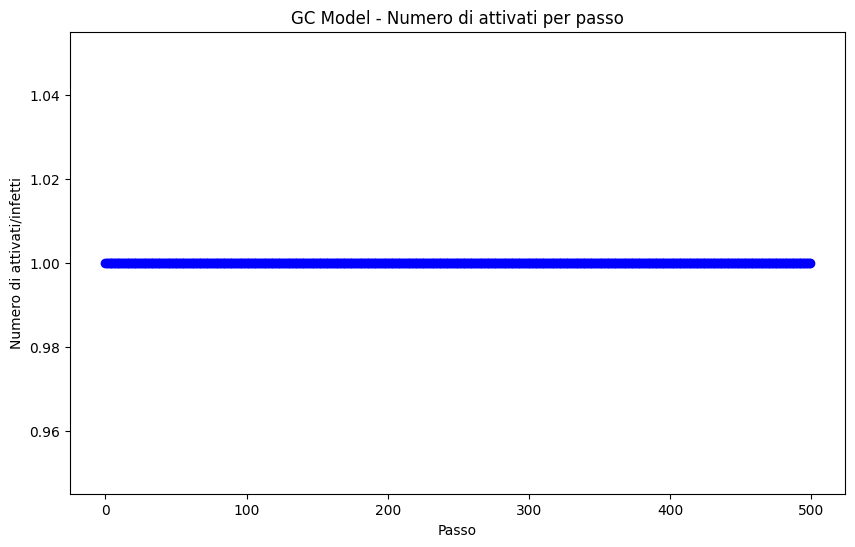

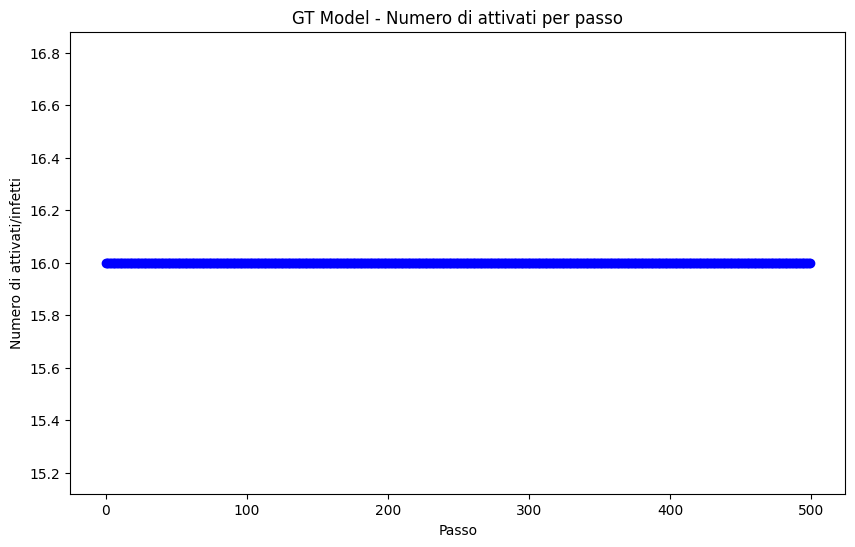

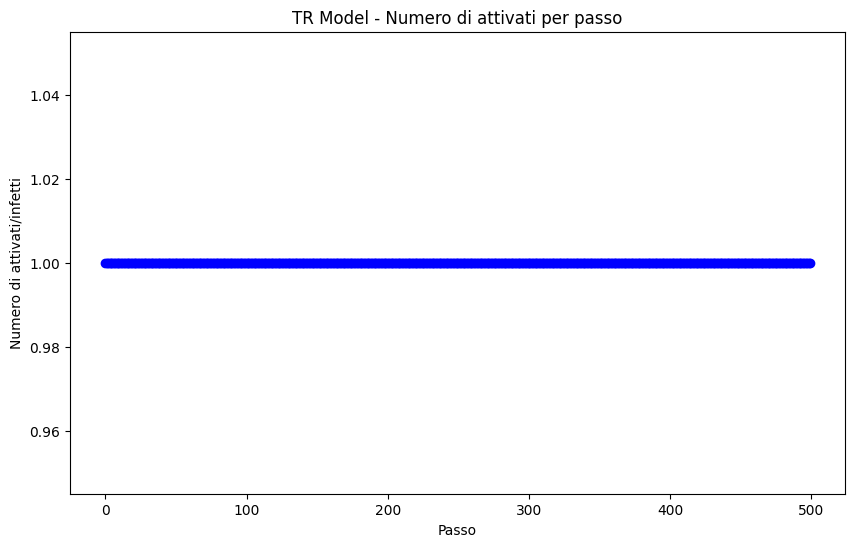

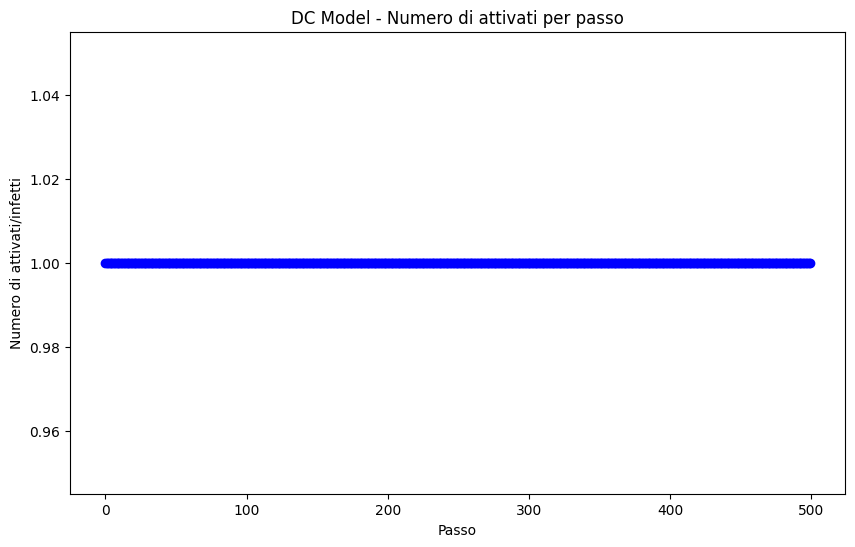

In [ ]:
import matplotlib.pyplot as plt

# Parametri di esempio per i modelli
beta = 0.1   # Probabilità di trasmissione (SI, SIR, SIS, SIRS)
gamma = 0.05  # Probabilità di recupero (SIR, SIS, SIRS)
lambda_ = 0.02  # Probabilità di perdere l'immunità (SIRS)
steps = 100  # Numero di passi per ogni simulazione
initial_prob = 0.1  # Probabilità iniziale per il modello DC
decay_factor = 0.95  # Decadimento della probabilità (Decreasing Cascade)
thresholds = {node: 0.3 for node in G.nodes}  # Soglia di attivazione per ogni nodo (GT)
k = 5  # Numero di nodi da selezionare per la massimizzazione dell'influenza

# Esecuzione dei modelli
print("Simulazione SI Model")
si_results = simulate_si(G, beta, steps)

print("Simulazione SIR Model")
sir_results = simulate_sir(G, beta, gamma, steps)

print("Simulazione SIS Model")
sis_results = simulate_sis(G, beta, gamma, steps)

print("Simulazione SIRS Model")
sirs_results = simulate_sirs(G, beta, gamma, lambda_, steps)

print("Simulazione General Cascade Model")
gc_results = simulate_gc(G, 0.1, steps)

print("Simulazione General Threshold Model")
gt_results = simulate_gt(G, thresholds, steps)

print("Simulazione Triggering Model")
tr_results = simulate_tr(G, 0.1, steps)

print("Simulazione Decreasing Cascade Model")
dc_results = simulate_dc(G, initial_prob, decay_factor, steps)


# Visualizzazione dei risultati
def plot_results(results, title, is_set=False):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    
    for i, state in enumerate(results):
        if is_set:
            # Conta il numero di nodi attivati (elementi nel set)
            activated_count = len(state)
        else:
            # Conta il numero di infetti ('I') nei dizionari
            activated_count = sum(1 for status in state.values() if status == 'I')
        
        plt.plot(i, activated_count, 'bo')
    
    plt.xlabel('Passo')
    plt.ylabel('Numero di attivati/infetti')
    plt.show()

# Ora, quando chiamiamo plot_results per i modelli GC, GT, TR e DC, passiamo True per il parametro is_set
plot_results(gc_results, "GC Model - Numero di attivati per passo", is_set=True)
plot_results(gt_results, "GT Model - Numero di attivati per passo", is_set=True)
plot_results(tr_results, "TR Model - Numero di attivati per passo", is_set=True)
plot_results(dc_results, "DC Model - Numero di attivati per passo", is_set=True)


# Massimizzazione dell'influenza

In [13]:
# Funzione di valutazione dell'influenza (generica per IC o LT)
def evaluate_spread(G, seed_nodes, model="IC", activation_prob=0.1):
    """
    Valuta la diffusione dell'influenza utilizzando il modello IC o LT.
    Params:
    - G: grafo orientato.
    - seed_nodes: lista di nodi seed.
    - model: modello di diffusione ("IC" o "LT").
    - activation_prob: probabilità di attivazione per il modello IC.

    Returns:
    - Il numero di nodi attivati.
    """
    if model == "IC":
        return len(independent_cascade_model(G, seed_nodes, activation_prob))
    elif model == "LT":
        return len(linear_threshold_model(G, seed_nodes))
    else:
        raise ValueError("Modello non supportato. Usa 'IC' o 'LT'.")


# Algoritmo Greedy per la Massimizzazione dell'Influenza
def influence_maximization_greedy(G, k, model="IC", activation_prob=0.1):
    """
    Algoritmo Greedy per la massimizzazione dell'influenza.
    Params:
    - G: grafo orientato.
    - k: numero di nodi seed da selezionare.
    - model: modello di diffusione ("IC" o "LT").
    - activation_prob: probabilità di attivazione per il modello IC.

    Returns:
    - best_seeds: lista di nodi seed selezionati.
    """
    best_seeds = []
    all_nodes = set(G.nodes())

    for _ in range(k):
        max_influence = -1
        best_node = None

        for node in all_nodes - set(best_seeds):
            spread = evaluate_spread(G, best_seeds + [node], model, activation_prob)
            if spread > max_influence:
                max_influence = spread
                best_node = node

        best_seeds.append(best_node)

    return best_seeds


# Algoritmo CELF per la Massimizzazione dell'Influenza
def influence_maximization_celf(G, k, model="IC", activation_prob=0.1):
    """
    Algoritmo CELF (Cost-Effective Lazy Forward) per la massimizzazione dell'influenza.
    Params:
    - G: grafo orientato.
    - k: numero di nodi seed da selezionare.
    - model: modello di diffusione ("IC" o "LT").
    - activation_prob: probabilità di attivazione per il modello IC.

    Returns:
    - best_seeds: lista di nodi seed selezionati.
    """
    # Lista delle influenze marginali per ciascun nodo
    marginals = []
    best_seeds = []
    all_nodes = set(G.nodes())

    # Prima valutazione per ogni nodo
    for node in all_nodes:
        spread = evaluate_spread(G, [node], model, activation_prob)
        marginals.append((spread, node))
    marginals.sort(reverse=True, key=lambda x: x[0])

    for _ in range(k):
        while True:
            # Prendi il nodo con la massima influenza marginale
            spread, node = marginals[0]
            # Ricalcola l'influenza marginale se è obsoleto
            new_spread = evaluate_spread(G, best_seeds + [node], model, activation_prob)
            marginals[0] = (new_spread, node)
            marginals.sort(reverse=True, key=lambda x: x[0])

            # Se il nodo in testa è aggiornato, lo seleziona
            if marginals[0][1] == node:
                best_seeds.append(node)
                marginals.pop(0)
                break

    return best_seeds




In [14]:

# Esempio di esecuzione della massimizzazione dell'influenza
k = 10  # Numero di nodi seed da selezionare
best_seeds_greedy = influence_maximization_greedy(G, k, model="IC")
best_seeds_celf = influence_maximization_celf(G, k, model="IC")

print(f"Miglior set di nodi iniziali con algoritmo Greedy (k={k}):", best_seeds_greedy)
print(f"Miglior set di nodi iniziali con algoritmo CELF (k={k}):", best_seeds_celf)

Miglior set di nodi iniziali con algoritmo Greedy (k=10): [59097305524, 2038187293, 61261364350, 39199868, 69010522494, 60565363043, 27334609, 6234915356, 64476028282, 369604719]
Miglior set di nodi iniziali con algoritmo CELF (k=10): [1932667066, 47767634100, 8626653866, 57628588140, 62851285878, 1565557903, 478843704, 388536577, 48613075450, 34109979372]


# Visualizzazione

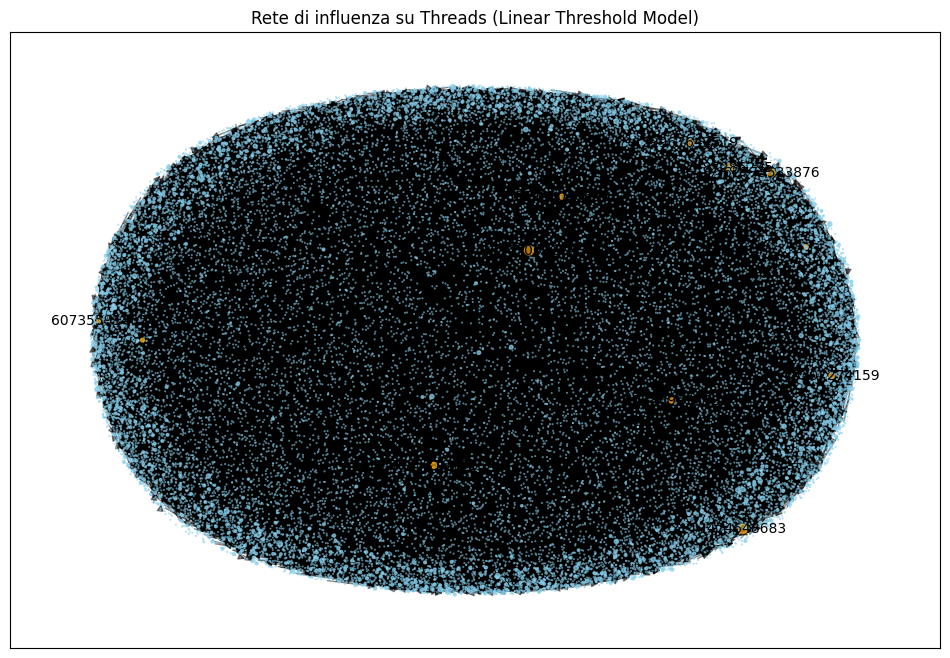

In [15]:
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.15)
node_colors = ["orange" if node in activated_nodes_lt else "skyblue" for node in G.nodes()]
node_sizes = [centralities.get("PageRank")[node] * 10000 for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.7)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, {node: node for node, _ in top_influencers}, font_size=10)
plt.title("Rete di influenza su Threads (Linear Threshold Model)")
plt.show()